In [1]:
import numpy as np
import pandas as pd
import matplotlib.pylab as plt

from getpass import getpass
from coreapi.auth import BasicAuthentication
from quantuminspire.api import QuantumInspireAPI
from quantuminspire.credentials import load_account, get_token_authentication, get_basic_authentication
from quantuminspire.api import QuantumInspireAPI

In [2]:
print('Enter mail address')
email = input()

print('Enter password')
password = getpass()

server_url = r'https://api.quantum-inspire.com'
authentication = BasicAuthentication(email, password)
qi = QuantumInspireAPI(server_url, authentication)

Enter mail address
y.zhang-108@student.tudelft.nl
Enter password
········


In [3]:
qi.list_backend_types()

Backend type: Spin-2, number of qubits: 2
Backend type: Starmon-5, number of qubits: 5
Backend type: QX single-node simulator, number of qubits: 26
Backend type: QX single-node simulator SurfSara, number of qubits: 31


In [4]:
def QKD_QACM_Economic(key,A_base,B_base,E_base):
    
    # here the qubits used in circuit is 1,3 instead of 0,4, for lower error rate
    
    # q[0] is Bob's qubit and q[1] is Eve‘s qubit
    
    qasm ='''
    version 1.0
    qubits 2
    
    # initialize the state
    {0}
    
    Sdag q[1]
    H q[1]
    Tdag q[1]
    CNOT q[0],q[1]
    T q[1]
    H q[1]
    S q[1]
    CNOT q[1],q[0]

    #Rotate back and measure
    {1}
    {2}
    '''
    if A_base:
        prep="prep_x q[0]\n"
        if key:
            prep+="    Z q[0]\n"
    else:
        prep="prep_z q[0]\n"
        if key:
            prep+="    X q[0]\n"
            
    meas="measure_x q[0]\n" if B_base else "measure_z q[0]"
    invasion="measure_x q[1]\n" if E_base else "measure_z q[1]"
    
    return qasm.format(prep,meas,invasion)

In [5]:
def sample_error_rate(data_sheet,N):
    sample=data_sheet.sample(N)
    return sum(sample["m_Bob"]!=sample["key"])/N

In [6]:
def sample_series(data_sheet,N_series,M):
    L=len(N_series)
    means=np.zeros(L)
    devs=np.zeros(L)
    for i in range(L):
        samp=[sample_error_rate(data_sheet,N_series[i]) for m in range(M)]
        means[i]=np.mean(samp)
        devs[i]=np.std(samp)
    return means,devs

In [7]:
#[bin(int(i))[2:].zfill(5) for i in hist.keys()]
@np.vectorize
def to_XZ(i):
    return ("Z","X")[i]

Economic QACM on spin-2

In [8]:
n_key=64
bitstring = np.random.randint(2,size=n_key)
bases_A=np.random.randint(2,size=n_key)
bases_B=bases_A.copy()
# bases_B=np.random.randint(2,size=n_key)
bases_E=bases_B.copy() # assume quantum memory

In [10]:
N_shots=1
backend_type = qi.get_backend_type_by_name('Spin-2')

data=[]
index=0

for param in zip(bitstring,bases_A,bases_B,bases_E):
#     if index<146:
#         index+=1
#     else:
    qasm=QKD_QACM_Economic(*param)
    result = qi.execute_qasm(qasm, backend_type=backend_type, number_of_shots=N_shots)
    key=bin(int(list(result.get('histogram', {}).keys())[0]))[2:].zfill(5)
    hist=list(result.get('histogram', {}).values())
    data.append(key)
    index+=1

    print(str(index)+"/"+str(n_key))
    print("Execution time: ", result.get('execution_time_in_seconds',{}))
    print("key:{0},bases_Alice:{1},bases_Bob:{2},bases_Eve:{3}".format(*param))
    print(key)
    print(hist)

1/64
Execution time:  0.00286282666666667
key:0,bases_Alice:1,bases_Bob:1,bases_Eve:1
00000
[1.0]
2/64
Execution time:  0.00286282666666667
key:0,bases_Alice:1,bases_Bob:1,bases_Eve:1
00000
[1.0]
3/64
Execution time:  0.00286260666666667
key:1,bases_Alice:0,bases_Bob:0,bases_Eve:0
00010
[1.0]
4/64
Execution time:  0.00286282666666667
key:0,bases_Alice:1,bases_Bob:1,bases_Eve:1
00001
[1.0]
5/64
Execution time:  0.00286260666666667
key:1,bases_Alice:0,bases_Bob:0,bases_Eve:0
00001
[1.0]
6/64
Execution time:  0.00286282666666667
key:0,bases_Alice:1,bases_Bob:1,bases_Eve:1
00001
[1.0]
7/64
Execution time:  0.00286260666666667
key:1,bases_Alice:0,bases_Bob:0,bases_Eve:0
00001
[1.0]
8/64
Execution time:  0.00286282666666667
key:0,bases_Alice:1,bases_Bob:1,bases_Eve:1
00011
[1.0]
9/64
Execution time:  0.00286282666666667
key:1,bases_Alice:1,bases_Bob:1,bases_Eve:1
00011
[1.0]
10/64
Execution time:  0.00286282666666667
key:1,bases_Alice:1,bases_Bob:1,bases_Eve:1
00010
[1.0]
11/64
Execution tim

In [11]:
data_sheet=DataFramet=pd.DataFrame(\
    data=np.vstack([bitstring,to_XZ(bases_A),list(map(lambda x: x[2], np.array(data))),list(map(lambda x: x[4], np.array(data)))]).transpose(),\
    columns=["key","bases","m_Bob","m_Eve"])
data_sheet.head()

data_sheet.to_excel("QKD_Economic_Simulation_64.xlsx")

<ErrorbarContainer object of 3 artists>

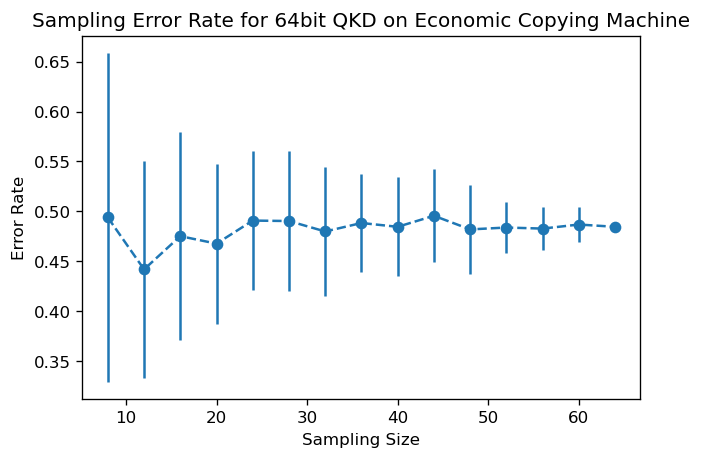

In [17]:
X=np.arange(8,65,4)
Y,std=sample_series(data_sheet,X,40)

plt.figure(dpi=120)
plt.xlabel("Sampling Size")
plt.ylabel("Error Rate")
plt.title("Sampling Error Rate for 64bit QKD on Economic Copying Machine")
plt.errorbar(x=X,y=Y,yerr=std,marker="o",linestyle='--')

In [16]:
Y.mean(),Y.std()

(0.4817306952306952, 0.008508902636352622)